# 2. Skip-gram with negative sampling

I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture3.pdf
* http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
from IPython.display import Image, display

In [2]:
print(torch.__version__)
print(nltk.__version__)

0.2.0+751198f
3.2.4


In [3]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [4]:
def getBatch(batch_size,train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex:eindex]
        temp = eindex
        eindex = eindex+batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [5]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if w in word2index.keys() else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word,word2index):
    return Variable(LongTensor([word2index[word]]) if word in word2index.keys() else LongTensor([word2index["<UNK>"]]))

## Data load and Preprocessing 

In [6]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:500]
corpus = [[word.lower() for word in sent] for sent in corpus]

### Exclude sparse words 

In [7]:
word_count = Counter(flatten(corpus))

In [8]:
MIN_COUNT=3
exclude=[]

In [9]:
for w,c in word_count.items():
    if c<MIN_COUNT:
        exclude.append(w)

### Prepare train data 

In [10]:
vocab = list(set(flatten(corpus))-set(exclude))

In [11]:
word2index={}
for vo in vocab:
    if vo not in word2index.keys():
        word2index[vo]=len(word2index)
        
index2word={v:k for k,v in word2index.items()}

In [12]:
WINDOW_SIZE = 5
windows =  flatten([list(nltk.ngrams(['<DUMMY>']*WINDOW_SIZE+c+['<DUMMY>']*WINDOW_SIZE,WINDOW_SIZE*2+1)) for c in corpus])

train_data = []

for window in windows:
    for i in range(WINDOW_SIZE*2+1):
        if window[i] in exclude or window[WINDOW_SIZE] in exclude: continue # min_count
        if i==WINDOW_SIZE or window[i]=='<DUMMY>': continue
        train_data.append((window[WINDOW_SIZE],window[i]))

X_p=[]
y_p=[]

for tr in train_data:
    X_p.append(prepare_word(tr[0],word2index).view(1,-1))
    y_p.append(prepare_word(tr[1],word2index).view(1,-1))
    
train_data = list(zip(X_p,y_p))

In [13]:
len(train_data)

50242

### Build Unigram Distribution**0.75 

$$P(w)=U(w)^{3/4}/Z$$

In [14]:
Z = 0.001

In [15]:
word_count = Counter(flatten(corpus))
num_total_words = sum([c for w,c in word_count.items() if w not in exclude])

In [16]:
unigram_table=[]

for vo in vocab:
    unigram_table.extend([vo]*int(((word_count[vo]/num_total_words)**0.75)/Z))

In [17]:
print(len(vocab),len(unigram_table))

478 3500


### Negative Sampling 

In [18]:
def negative_sampling(targets,unigram_table,k):
    batch_size = targets.size(0)
    neg_samples=[]
    for i in range(batch_size):
        nsample=[]
        target_index = targets[i].data.cpu().tolist()[0] if USE_CUDA else targets[i].data.tolist()[0]
        while len(nsample)<k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg]==target_index:continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample,word2index).view(1,-1))
    
    return torch.cat(neg_samples)

## Modeling 

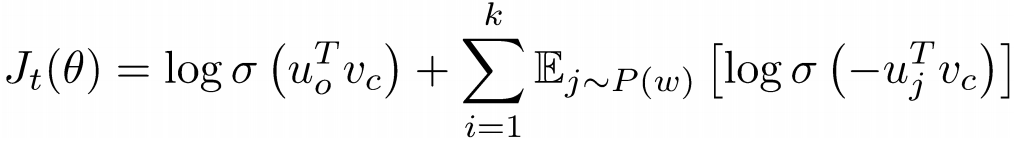

In [2]:
Image('../images/02.skipgram-objective.png') # borrowed imaged from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture3.pdf

In [19]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size,projection_dim):
        super(SkipgramNegSampling,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                
        initrange = (2.0 / (vocab_size+projection_dim))**0.5 # Xavier init
        self.embedding_v.weight.data.uniform_(-initrange, initrange) # init
        self.embedding_u.weight.data.uniform_(-0.0, 0.0) # init
        
    def forward(self, center_words,target_words,negative_words):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D
        
        neg_embeds = -self.embedding_u(negative_words) # B x K x D
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1,2)).squeeze(2) # Bx1
        negative_score = torch.sum(neg_embeds.bmm(center_embeds.transpose(1,2)).squeeze(2),1).view(negs.size(0),-1) # BxK -> Bx1
        
        loss = self.logsigmoid(positive_score) + self.logsigmoid(negative_score)
        
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

## Train 

In [68]:
EMBEDDING_SIZE = 30 
BATCH_SIZE = 256
EPOCH = 100
NEG=10 # Num of Negative Sampling

In [69]:
losses = []
model = SkipgramNegSampling(len(word2index),EMBEDDING_SIZE)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
for epoch in range(EPOCH):
    for i,batch in enumerate(getBatch(BATCH_SIZE,train_data)):
        
        inputs, targets = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        negs = negative_sampling(targets,unigram_table,NEG)
        model.zero_grad()

        loss = model(inputs,targets,negs)
        
        loss.backward()
        optimizer.step()
    
        losses.append(loss.data.tolist()[0])
    if epoch % 10==0:
        print("Epoch : %d, mean_loss : %.02f" % (epoch,np.mean(losses)))
        losses=[]

Epoch : 0, mean_loss : 1.06
Epoch : 10, mean_loss : 0.86
Epoch : 20, mean_loss : 0.79
Epoch : 30, mean_loss : 0.74
Epoch : 40, mean_loss : 0.71
Epoch : 50, mean_loss : 0.69
Epoch : 60, mean_loss : 0.67
Epoch : 70, mean_loss : 0.65
Epoch : 80, mean_loss : 0.64
Epoch : 90, mean_loss : 0.63


## Test 

In [71]:
def word_similarity(target,vocab):
    if USE_CUDA:
        target_V = model.prediction(prepare_word(target,word2index))
    else:
        target_V = model.prediction(prepare_word(target,word2index))
    similarities=[]
    for i in range(len(vocab)):
        if vocab[i] == target: continue
        
        if USE_CUDA:
            vector = model.prediction(prepare_word(list(vocab)[i],word2index))
        else:
            vector = model.prediction(prepare_word(list(vocab)[i],word2index))
        
        cosine_sim = F.cosine_similarity(target_V,vector).data.tolist()[0]
        similarities.append([vocab[i],cosine_sim])
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

In [212]:
test = random.choice(list(vocab))
test

'passengers'

In [213]:
word_similarity(test,vocab)

[['am', 0.7353377342224121],
 ['passenger', 0.7154150605201721],
 ['cook', 0.6829826831817627],
 ['new', 0.6648461818695068],
 ['bedford', 0.6283411383628845],
 ['besides', 0.5972960591316223],
 ['themselves', 0.5964340567588806],
 ['grow', 0.5957046151161194],
 ['tell', 0.5952941179275513],
 ['get', 0.5943044424057007]]